# Learning dynamics

参考来源： https://github.com/iyerkri/demos

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from utils import make_plot

----

## General 2x2 games

We test out the two versions of the best response dynamics for a general two-player two-actions game. The following code defines the payoff matrices for the two players. (Commented out code defines some other payoff matrices worth analyzing.)

In [23]:
# payoff matrix for the two players in the 2x2 game
# first two rows are player 1's payoff matrix, and the last two player 2's

payoff_matrix = np.zeros([4,2])


# payoff_matrix[:2,:] = [[1, -2],[-3, 1]]
# payoff_matrix[2:,:] = [[-3, 1],[5, -1]]



# matching pennies
payoff_matrix[:2,:] = [[1, -1],[-1, 1]]
payoff_matrix[2:,:] = [[-1, 1],[1, -1]]


# coordination game
#payoff_matrix[:2,:] = [ [1, 0], [0, 2]]
#payoff_matrix[2:,:] = [ [2, 0], [0, 1]]


# prisoner's dilemma
#payoff_matrix[:2,:] = [ [-1, -10], [0, -5]]
#payoff_matrix[2:,:] = [ [-1, 0], [-10, -5]]

# random game (with positive payoffs in [0,1])
#payoff_matrix = np.random.rand(4,2)

# random zero sum game (with positive payoffs for player 1 in [0,1])
#payoff_matrix = np.random.rand(4,2)
#payoff_matrix[2:,:]=-payoff_matrix[:2,:]

For these payoff matrices, we compute the best response dynamics, using the following code.

In [24]:
# number of iterations
num_iter = 20

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = np.zeros([num_iter,3])


payoffs = np.zeros([2,2])


for i in range(1,num_iter):

    # calculate payoff of player 1 assuming player 2 plays the strategy played in the previous round
    payoffs[0,0] = (1- strategy[i-1,1])*payoff_matrix[0,0] + strategy[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1- strategy[i-1,1])*payoff_matrix[1,0] + strategy[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming player 1 plays the strategy played in the previous round
    payoffs[0,1] = (1-strategy[i-1,0])*payoff_matrix[2,0] + strategy[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-strategy[i-1,0])*payoff_matrix[2,1] + strategy[i-1,0]*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 0
    else:
        strategy[i,1] = strategy[i-1,1]


    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter

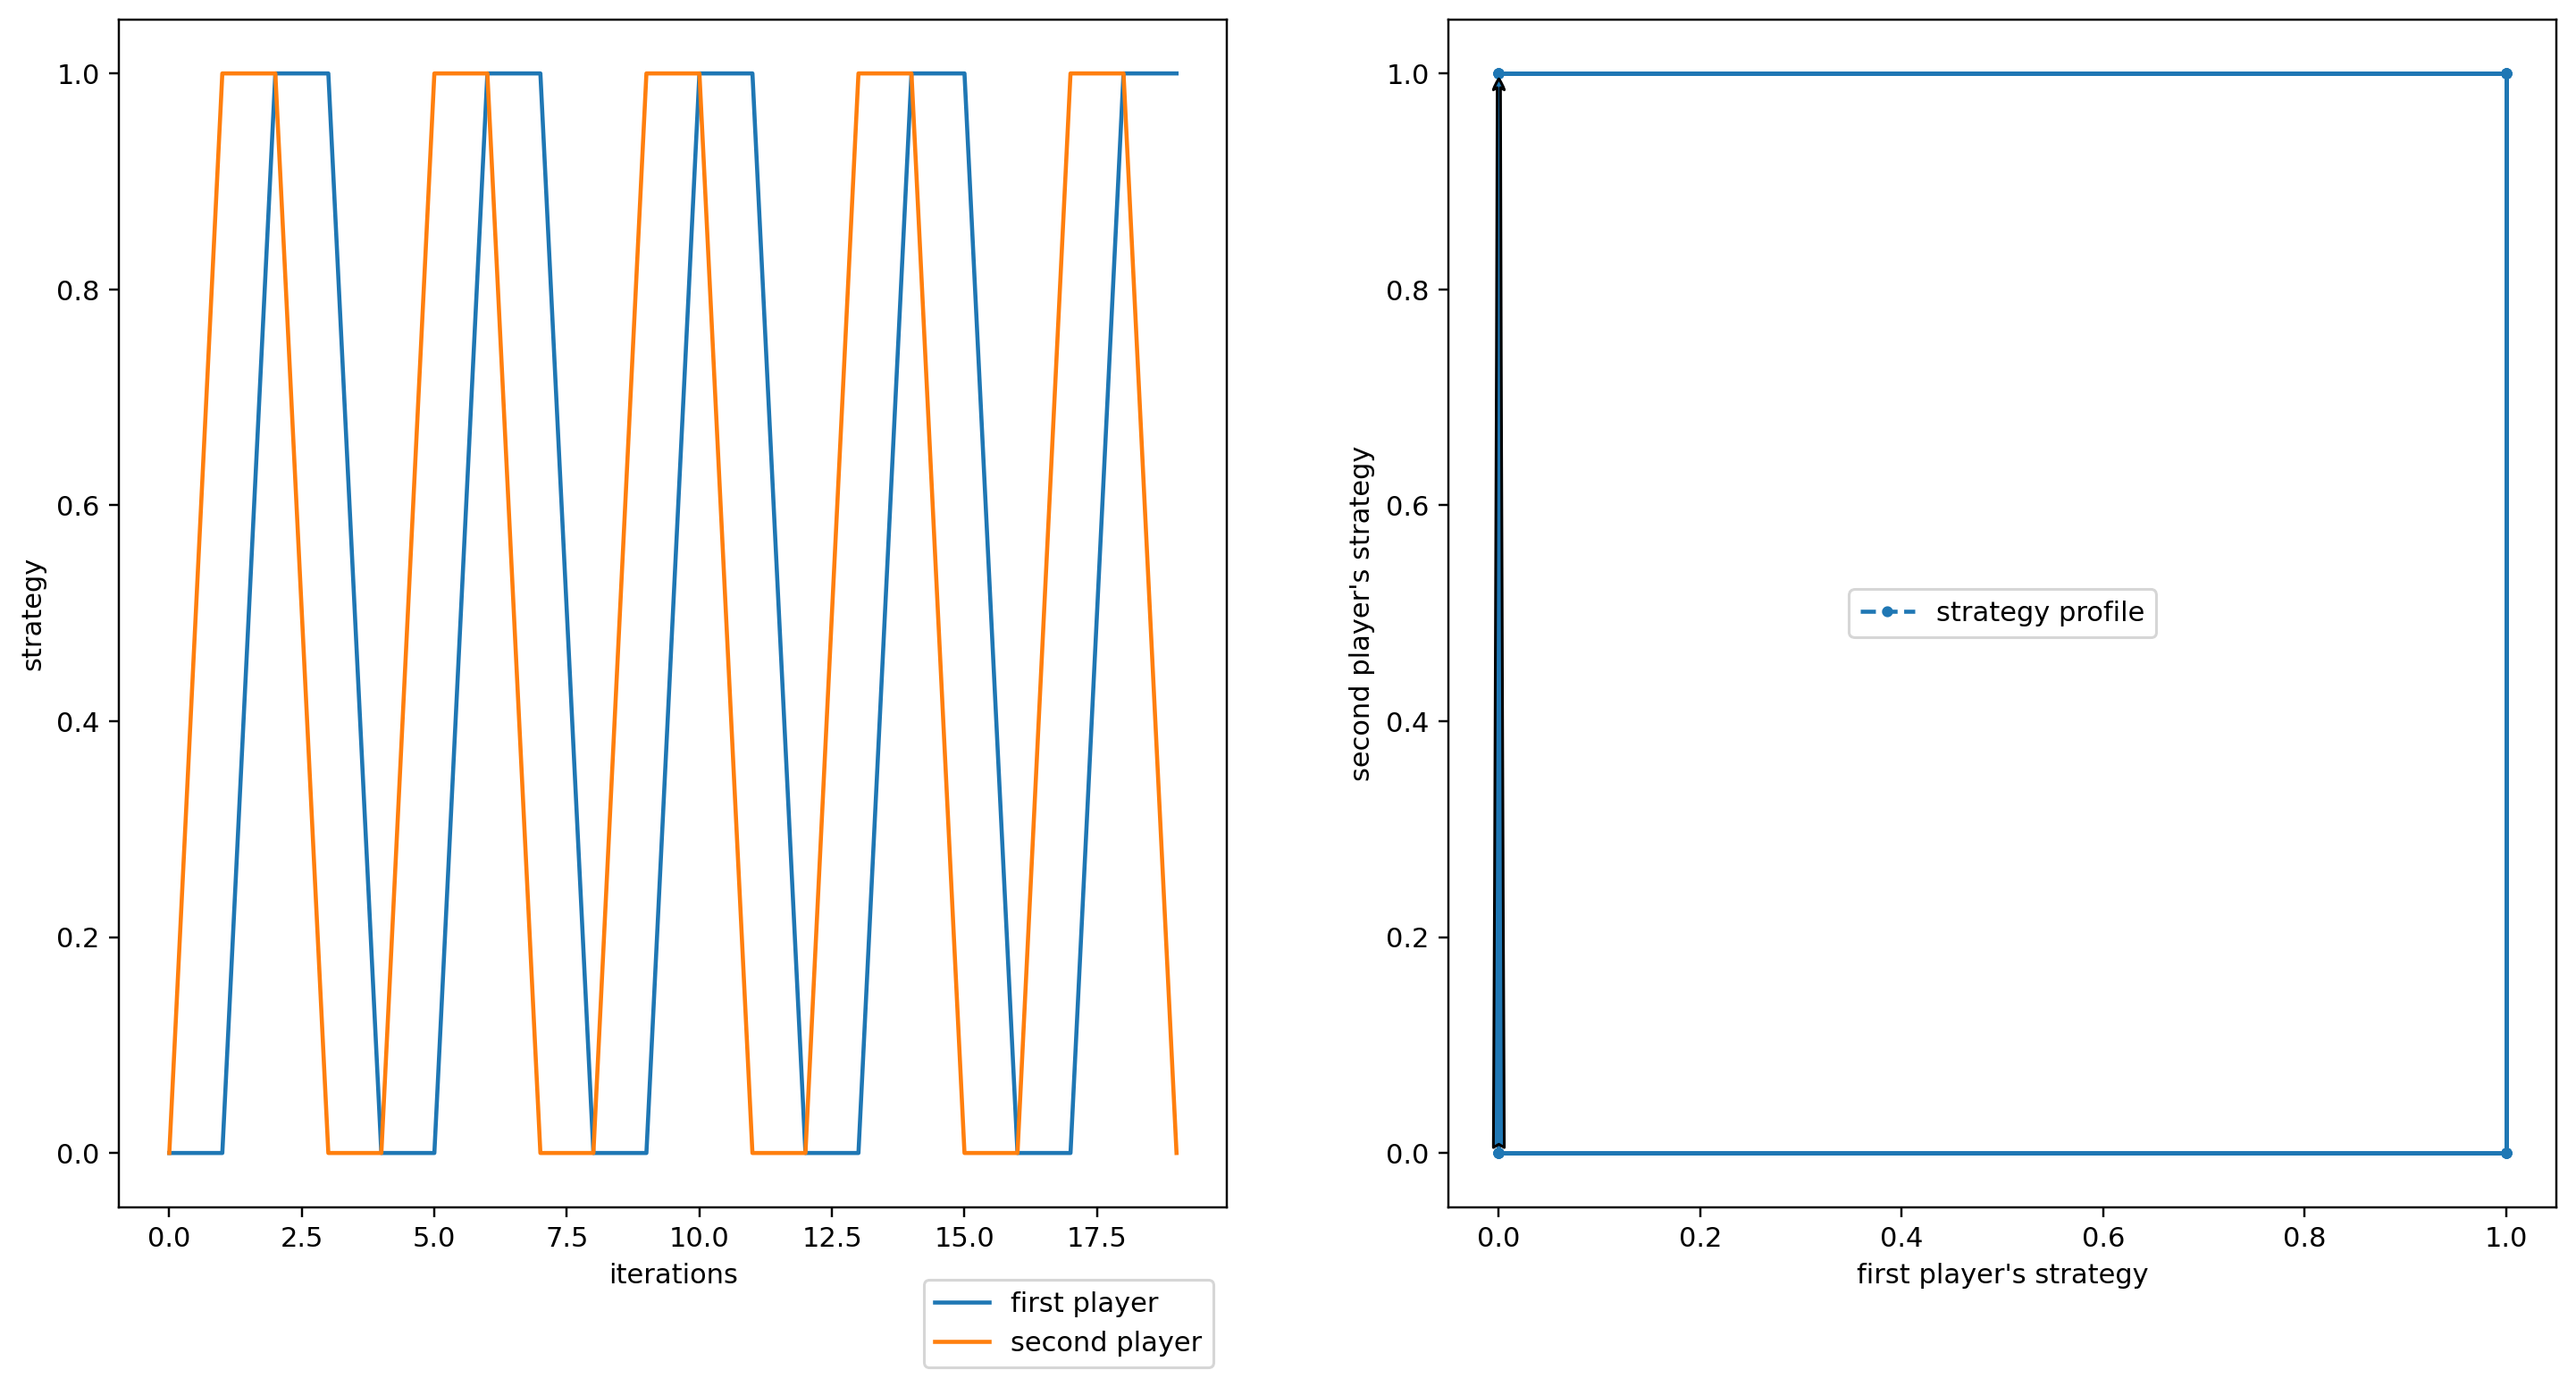

In [25]:
make_plot(strategy)

From the plot, we see that the best response dynamics does not converge, but keeps cycling between the four strategy profiles. Thus, we have an example of a game where the best-response dynamics fails to find the mixed Nash equilibrium.

Moreover, as the following plots show, the damped version of the best response dynamics also fails to converge, even after 1000 iterations. 

In [26]:
# damping factor
alpha = 0.1

# number of iterations
num_iter = 1000

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = np.zeros([num_iter,3])

payoffs = np.zeros([2,2])

for i in range(1,num_iter):

    # calculate payoff of player 1 assuming player 2 plays the strategy played in the previous round
    payoffs[0,0] = (1- strategy[i-1,1])*payoff_matrix[0,0] + strategy[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1- strategy[i-1,1])*payoff_matrix[1,0] + strategy[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming player 1 plays the strategy played in the previous round
    payoffs[0,1] = (1-strategy[i-1,0])*payoff_matrix[2,0] + strategy[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-strategy[i-1,0])*payoff_matrix[2,1] + strategy[i-1,0]*payoff_matrix[3,1]


    # player 1's best response with damping
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = (1-alpha)*strategy[i-1,0] + alpha*1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = (1-alpha)*strategy[i-1,0] + alpha*0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response with damping
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = (1-alpha)*strategy[i-1,1] + alpha*1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = (1-alpha)*strategy[i-1,1] + alpha*0
    else:
        strategy[i,1] = strategy[i-1,1]


    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter

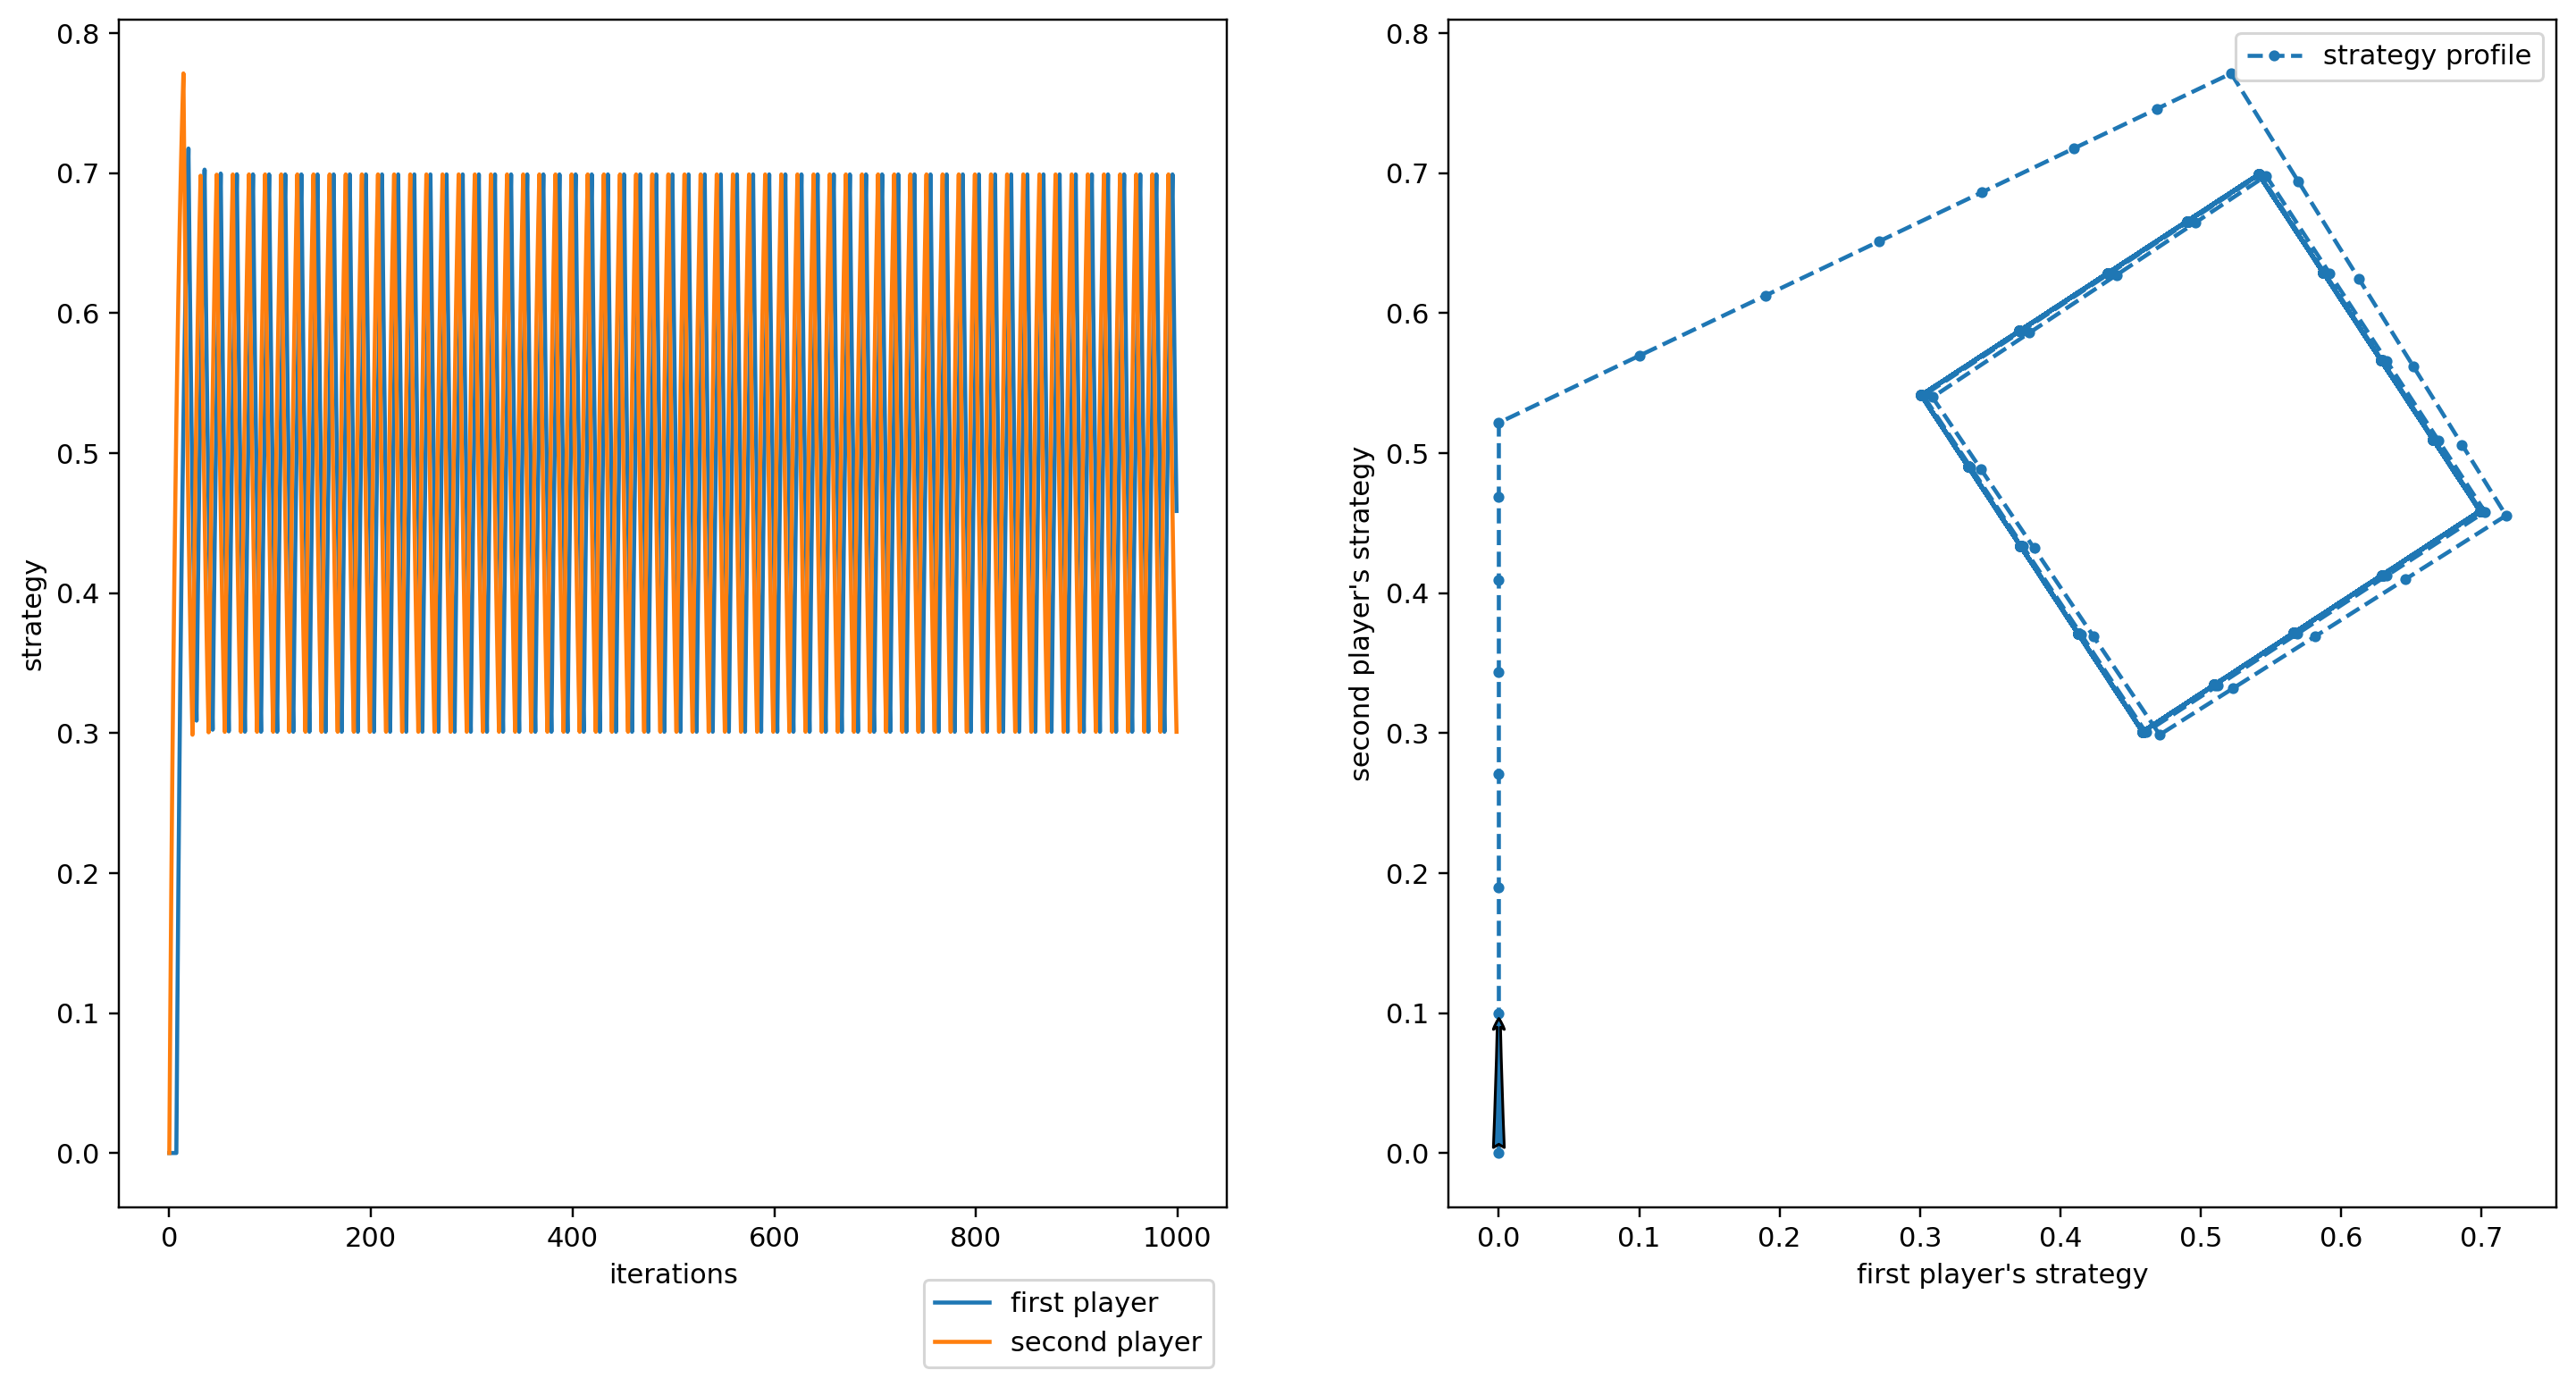

In [27]:
make_plot(strategy)

Again, after 1000 iterations, the damped best response dynamics seems to have stuck in a cycle of four mixed strategy profiles. As the reader can easily verify, increasing the number of iterations of the dynamics does not lead to convergence. 

## Fictitious Play

One reason why best response dynamics fails to converge is that the
players, by playing the best response to only what was played in the
previous time period, forget all that was played before. In fact this
"forgetting the past" feature of best response dynamics ensures that
the convergence, if it happens, is fast. But this also ensures that
the strategies swing wildly when there is no convergence.

One possible remedy is to consider not just what was played the
previous time period, but at all the time periods before time $t$ when
choosing a best response. This leads to a learning dynamics known as
\textit{fictitious play}, introduced by George Brown \cite{brown1951} and
further analyzed by Julia Robinson \cite{robinson1951iterative} in 1951. Here, each player assumes that the other players' strategies are given by the respective empirical distributions of their actions.

To formally define fictitious play, we begin by defining the empirical
distribution at time $t$, which is given by
\begin{align*}
  \gamma_i^t(s) &=  \frac{\text{Number of times a pure strategy $s$ was played by player $i$ before time $t$}}{t}\\
                &= \frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{I}\{ s_i^\tau = s\} , \quad \text{for all $s \in \mathcal{S}_i$}.
\end{align*}
(Note $\mathbf{I}\{A\}$ is equal
to $1$ if $A$ is true, and zero otherwise.) 

The empirical distribution $\gamma_i^t$ denotes a distribution over
the set of pure strategies, with $\gamma_i^t(s)$ denoting the fraction
of the time until time $t$ that player $i$ played (pure) strategy
$s$. Let
$\gamma_{-i}^t = (\gamma_1^t , \cdots,\gamma_{i-1}^t, \gamma_{i+1}^t ,
\cdots, \gamma_N^t)$ denote the empirical distribution of all players
other than player $i$.


In fictitious play, each player $i$ at each time $t\geq 1$, assumes
that all other players are choosing their strategies according to the
empirical distribution $\gamma_{-i}^t$, and plays a best
response. Formally, for all $t \geq 1$, and for each $i$, we have
\begin{align*}
\sigma_i^t \in BR_i(\gamma_{-i}^{t}).
\end{align*}

The following code computes the players' strategies and the empirical distributions under fictitious play for the 2x2 game considered earlier.

In [28]:
# number of iterations
num_iter = 5000

# 'strategy' stores each players' mixed strategy (probability of action 1 in each case)
strategy = np.zeros([num_iter,3])

# 'empirical' stores the empirical distribution of each players' actions
empirical = np.zeros([num_iter,3])

payoffs = np.zeros([2,2])

for i in range(1,num_iter):
    
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = (1-empirical[i-1,1])*payoff_matrix[0,0] + empirical[i-1,1]*payoff_matrix[0,1]
    payoffs[1,0] = (1-empirical[i-1,1])*payoff_matrix[1,0] + empirical[i-1,1]*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = (1-empirical[i-1,0])*payoff_matrix[2,0] + empirical[i-1,0]*payoff_matrix[3,0]
    payoffs[1,1] = (1-empirical[i-1,0])*payoff_matrix[2,1] + empirical[i-1,0]*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 1
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 0
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 1
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 0
    else:
        strategy[i,1] = strategy[i-1,1]


    # update the empirical distribution
    empirical[i,0] = ((i-1)*empirical[i-1,0] + strategy[i,0])/i
    empirical[i,1] = ((i-1)*empirical[i-1,1] + strategy[i,1])/i
        
    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter
    empirical[i,2] = i/num_iter

We first plot the strategy of the two players.

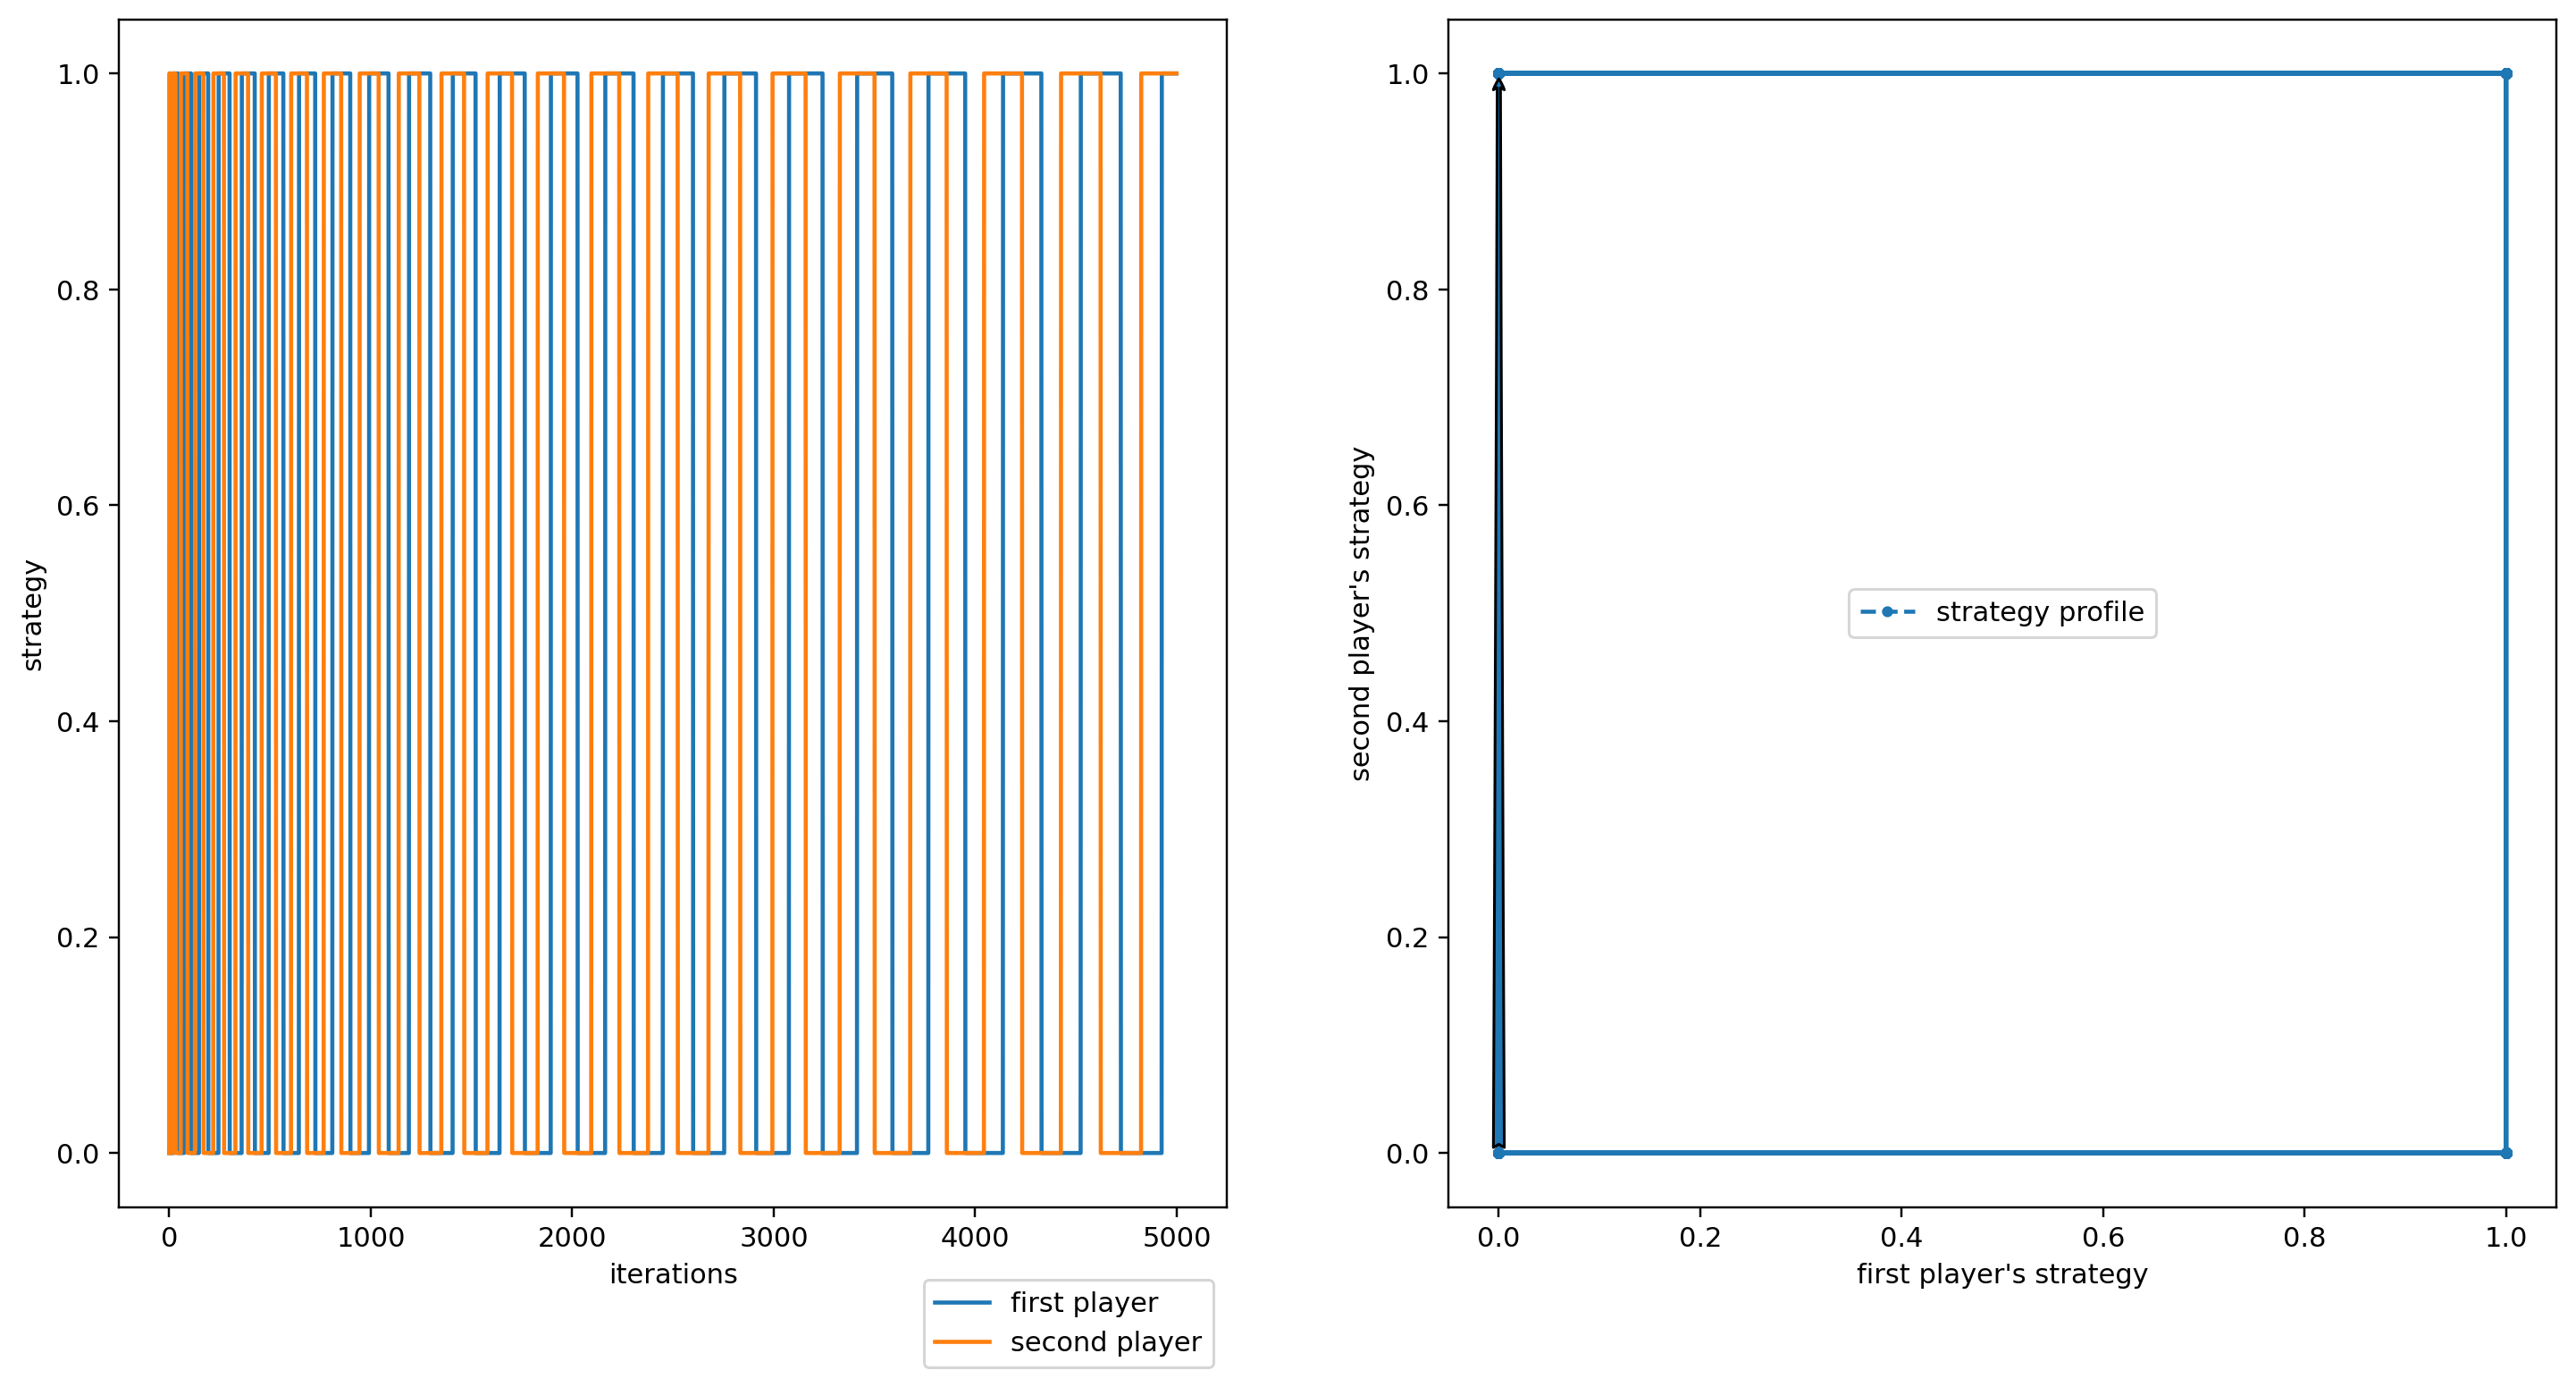

In [29]:
make_plot(strategy)

Despite considering the entire past history of other players' actions which choosing her own, we see that, disappointingly, the strategies of the two players still do not converge. Instead, they keep cycling among the same set of pure strategy profiles.

Given this, let's plot the empirical distribution.

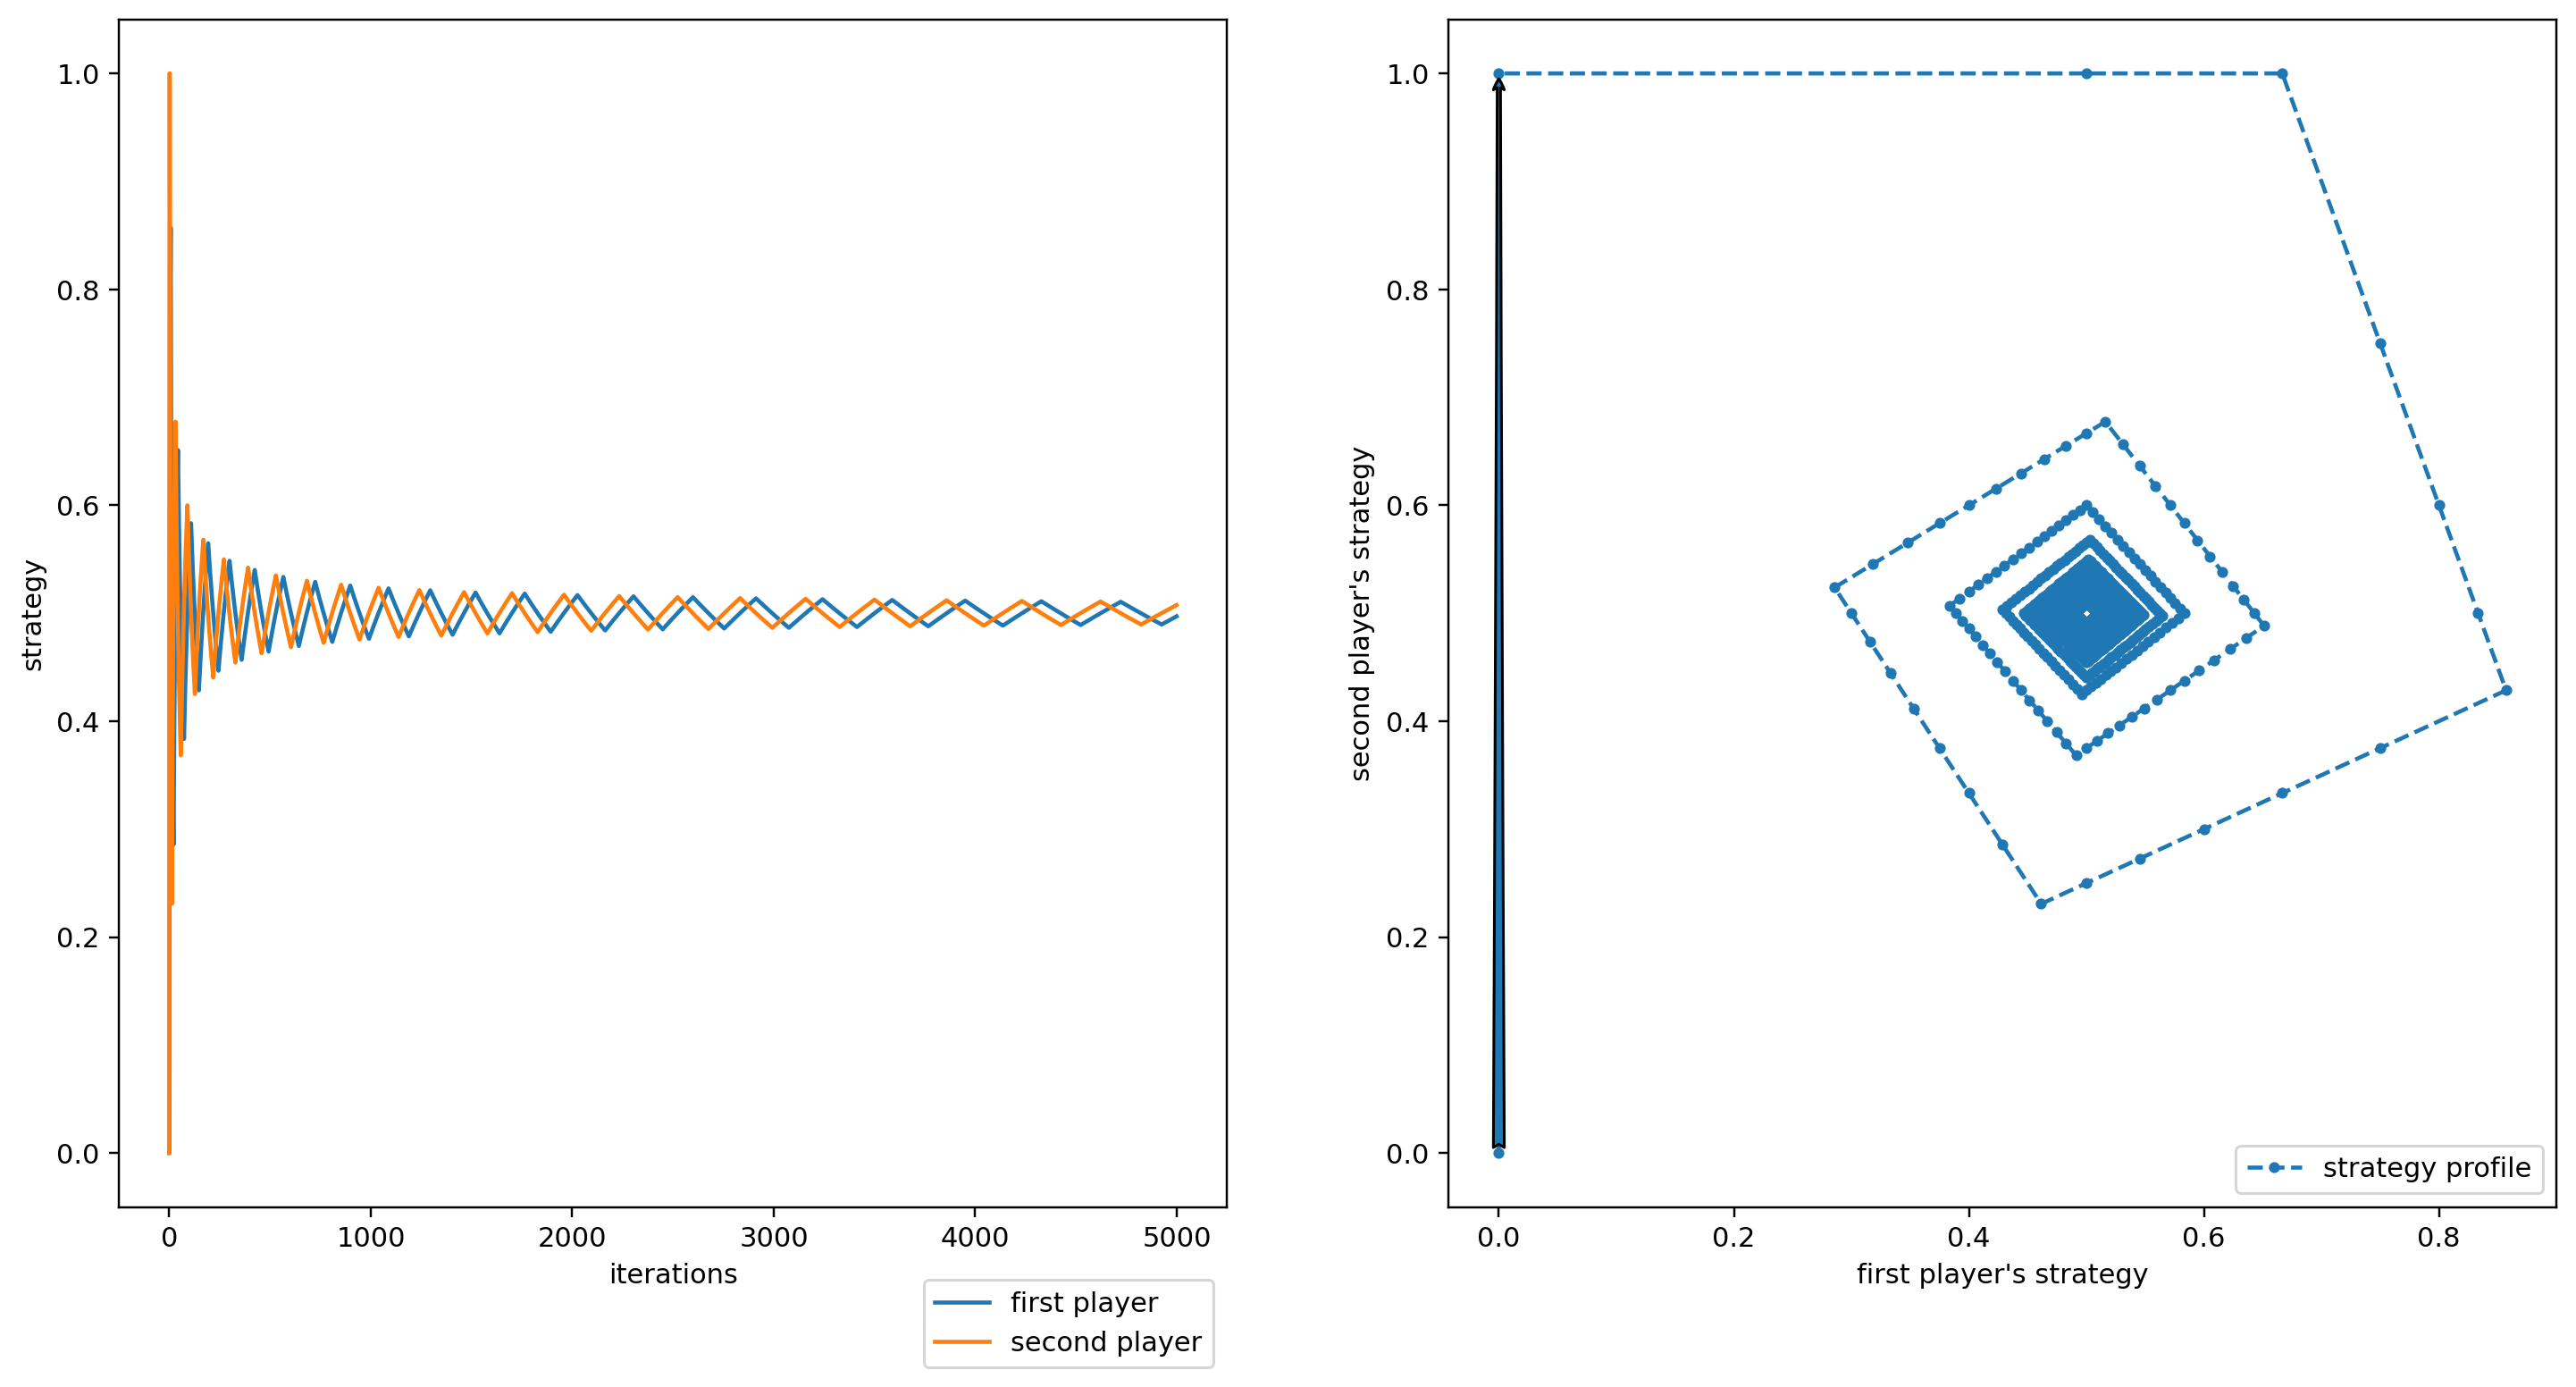

In [30]:
make_plot(empirical)

Interestingly, we see that the empirical distributions indeed converge. (The amplitude of the oscillation becomes smaller with more iterations, as can be easily checked.) It is also easy to verify that the limiting probabilities actually constitute a mixed Nash equilibrium. This mixed Nash equilibrium is (approximately) given by

In [31]:
print("Player 1's strategy: ["+ str(round(empirical[num_iter-1,0],3))
      + "," + str(round(1-empirical[num_iter-1,0],3)) + "]")
print("Player 2's strategy: ["+ str(round(empirical[num_iter-1,1],3))
      + "," + str(round(1-empirical[num_iter-1,1],3)) + "]")

Player 1's strategy: [0.497,0.503]
Player 2's strategy: [0.508,0.492]


Thus, we have an example of a setting where the best response dynamics does not converge, but under fictitious play, the empirical distribution $\gamma^t$ converges. Using similar arguments as in the best response dynamics, one can show that if the empirical distribution under fictitious play converges, it must converge to a (mixed) Nash equilibrium. 


More interestingly, for many classes of games, one can show that under fictitious play, the empirical distribution $\gamma^t$ **must** converge (and hence must converge to a mixed Nash equilibrium). One such class of games is the class of \textit{zero-sum games}, which are two-player games where one
player's gain is another player's loss. (For details, refer \cite{robinson1951iterative}.) Similarly, the empirical distribution under fictitious play always converges for any game (with any number of players) that is _dominance solvable_. (For details, refer \cite{nachbar1990}.)


However, one can also show that there exist games where the fictitious
play does not converge, but cycles. In fact, there is currently no
known algorithm that always converges to a Nash equilibrium for a
general finite game. This is an open problem and an area of active
research.

# References

(<a id="cit-brown1951" href="#call-brown1951">Brown, 1951</a>) George W. Brown, ``_Iterative Solution of Games by Fictitious Play_'',  1951.

(<a id="cit-robinson1951iterative" href="#call-robinson1951iterative">Robinson, 1951</a>) Robinson Julia, ``_An iterative method of solving a game_'', Annals of mathematics, vol. , number , pp. 296--301,  1951.

(<a id="cit-nachbar1990" href="#call-nachbar1990">Nachbar, 1990</a>) Nachbar J. H., ``_``Evolutionary selection'' dynamics in games: Convergence and limit properties_'', International Journal of Game Theory, vol. 19, number 1, pp. 59--89, Mar 1990.

